In [7]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

In [8]:
# google driveから読み込む
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from scipy.io import loadmat

In [10]:
# MATLAB形式ファイルから読み込む
trainset = loadmat('/content/drive/My Drive/ColabNotebooks/DCGAN/data/train_32x32.mat')
testset = loadmat('/content/drive/My Drive/ColabNotebooks/DCGAN/data/test_32x32.mat')

73257


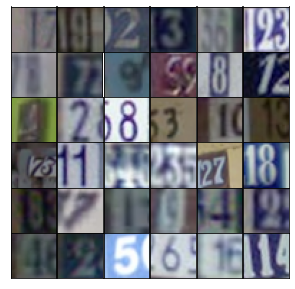

In [13]:
# ランダムな番号を生成(整数=0, 36枚取り出す)

idx = np.random.randint(0, trainset['X'].shape[3], size=36)
print(trainset['X'].shape[3])

# fig: 図全体 axes: 部分的な図
# 縦横6枚ずつ, 5インチかける5インチ
fig, axes = plt.subplots(6,6, sharex=True, sharey = True, figsize=(5,5),)

# zip: 引数にある二つの変数をまとめる
for ii, ax in zip(idx, axes.flatten()):
    # 一つのセル=axの中かでimgshowする、trainsetのX番目の中からii番目の画像データを表示し、equalで縦と横を同じにする
    ax.imshow(trainset['X'][:, :, :, ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
# マージンを指定
plt.subplots_adjust(wspace=0, hspace=0)

In [14]:
# データのスケールを揃える
# R, G, B(0-255) => 0-1に変換 => -1-1に変換する

def scale(x, feature_ranges=(-1, 1)):
    # x.min() xの要素の最小値を取得
    # これで 0-1に変換される(100%で255になればいい)
    x = ((x - x.min())/ (255 - x.min()))
    
    min, max = feature_ranges
    # -1 - 1の間に変換している
    x = x * (max - min) + min
    return x

In [15]:
# Datasetのクラスを定義する

class Dataset:
    # val_frac=0.5: testデータをバリデーション（学習中）用と学習後用に分離する
    # scale_func標準でスケールするファンクションを使うかどうか。今回は使わず、自前のものを使うのでnone
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        # 何番目まで、テストデータの一部をバリデーションに使うかどうか
        # testデータの'Y'の長から利率をひく
        split_index = int(len(test['y']) * (1 - val_frac))
        # テスト用のxとバリデーション用のX
        self.test_x, self.valid_x = test['X'][:, :, :, :split_index], test['X'][:, :, :, split_index:]
        self.test_y, self.valid_y = test['y'][:split_index], test['y'][split_index:]
        self.train_x, self.train_y = train['X'], train['y']

        # MATLAB形式{R,G,B,index}からTensorFlow形式に変換する {index, R,G,B}
        # Numpyのrollaxis関数を使用(行列のデータの並びを変換する)
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)

        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle

    # ミニバッチを生成するための関数(self: 自身, batcj_size: 全体から一部部分を抽出するその際のデータの個数)
    def batches(self, batch_size):
        if self.shuffle:
            # arange: 指定した範囲を抽出する
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]

        # 何回このバッチを取得するか    
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            # ii番目からbatch_siezまで=>[ii:ii+batch_size]
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]

            yield self.scaler(x), y

In [16]:
# 変数（プレースホルダー）を初期化する関数

def model_inputs(real_dim, z_dim):
    # tf.placeholder() is not compatible with eager execution.のエラーを防ぐ
    tf.compat.v1.disable_eager_execution()

    # *は可変長になるという意味
    inputs_real = tf.compat.v1.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.compat.v1.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [17]:
# ジェネレーターを定義しよう(100の長さの入力の文字から32*32*3というアウトプットを得る)

def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.compat.v1.variable_scope('generator', reuse=reuse):
        # この辺の数字の根拠は論文参照
        x1 = tf.compat.v1.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        # データの偏りを調整する処理
        x1 = tf.compat.v1.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1) # maximumで大きい方を採用する
        
        # conv2d_transpose=>畳み込み処理の逆の処理(deconvolution)
        # paddingをsameで入力と出力値が一緒
        x2 = tf.compat.v1.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.compat.v1.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2) # maximumで大きい方を採用する
        
        # 8*8*256のサイズになっている
        x3 = tf.compat.v1.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.compat.v1.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3) # maximumで大きい方を採用する
        
        # 16*16*128のサイズになっている
        logits = tf.compat.v1.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        # 32*32*3というサイズになったので-1~1の間の値に変換する
        out = tf.tanh(logits)
        
        return out

In [18]:
# ディスクリミネーターを定義しよう

def discriminator(x, reuse=False, alpha=0.2):
    with tf.compat.v1.variable_scope('discriminator', reuse=reuse):
        # 32*32*3のサイズ(畳み込みで小さくしていく)
        x1 = tf.compat.v1.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1= tf.maximum(alpha * x1, x1)
        
        # 16*16*64
        x2 = tf.compat.v1.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.compat.v1.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 8*8*128
        x3 = tf.compat.v1.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.compat.v1.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4*4*256
        flat = tf.reshape(x3, (-1, 4*4*256))
        # denseが全結合の式
        logits = tf.compat.v1.layers.dense(flat, 1)
        # sigmoidかけて0-1の間の値にする
        out = tf.sigmoid(logits)
        
        return out, logits

In [19]:
# 損失関数を定義しよう

def model_loss(input_real, input_z, output_dim, alpha=0.2):
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # discriminatorが本物を判定できるかの損失（tfのreducemeを使って平均をとっていく）
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    # fakeを正しく見破れるか
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    # generatorが偽物を作ってどれくらいそれがdにリアルと判定されるか
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

In [20]:
# 最適化処理を定義しよう

# dの損失とgの損失、学習率と、最適化の減衰率学習率をどれくらい減衰させるかの変数をとる
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.compat.v1.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.compat.v1.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.compat.v1.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [21]:
# モデルのテンプレート（クラス）を定義しよう

class GAN:
    # インスタンス作成時の初期処理(real_size: 本物のデータのサイズ, z_size: ノイズのサイズ, 学習率, alpha,beta1: optの減衰率=>結果が芳しくないときはこれを調整)
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.compat.v1.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [22]:
# 生成した画像を表示する関数の定義(epoch: エポック数, samples: 画像データセット, nrows: 何行で, nrows: 何列で, figsize=(5,5): サイズ)

def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box')
        im = ax.imshow(img, aspect='equal')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes 

In [23]:
# トレーニングの関数を定義しよう

def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.compat.v1.train.Saver()
    # サンプルを生成するためのノイズのレート（-1~1の中央分布サイズは72）
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    
    # 損失を格納しておくための空配列
    samples, losses = [], []
    steps = 0
    
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1
                
                # バッチの中で使うノイズを初期化（-1 ~ 1の中央分布）
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x })
                
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    
                    # 小数点以下4桁の浮動小数点 => :.4f
                    print("Epoch {}/{}: ".format(e + 1, epochs),
                              "D Loss: {:.4f} ".format(train_loss_d),
                              "G Loss: {:.4f} ".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(generator(net.input_z, 3, reuse=True, training=False),
                                          feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()
                    
            saver.save(sess, './checkpoints/generator.ckpt')
            
        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
            
        return losses, samples

In [24]:
# ハイパーパラメーターの初期化とトレーニングの実行

# realの画像サイズ(32 * 32のサイズでRGBの３色3チャンネル)
real_size = (32, 32, 3)
# ノイズのサイズを100
z_size = 100
# 学習率を少し小さめ（結果をみて調整）
learning_rate = 0.0002
# バッチのサイズ
batch_size = 128
# ミニバッチを何回回すか
epochs = 25
# dのスケールを変更する値
alpha = 0.2
# adamoptimizerの減衰のパラメーター
beta1 = 0.5

net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is depr

In [25]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

Output hidden; open in https://colab.research.google.com to view.